# Read Me

Please **execute the code blocks below one by one**, and the performance of training and the prediction of test data set will be generate at the last code block.

The markdown note before each code block describe the content of each code block

The predicted results can be opened by the following code:

---

```python
with h5py.File('../Output/Predicted_labels.h5','r') as H:

    test_label = np.copy(H['label'])
```

---

In [44]:
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt

np.random.seed(0)

Following is the activation class, including activations like: linear, tanh, logistic, relu, sigmoid, softmax and their derivatives

In [45]:
class Activation(object):
    def __linear(self, x):
        return x
    
    def __linear_deriv(self, a):
        return 1
    
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        '''partial derivative for each element of data under tanh(data)'''
        return 1.0 - a ** 2
           
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        return  a * (1 - a)
    
    def __relu(self, x):
        return np.maximum(0, x)
        
    def __relu_deriv(self, a):
        a[a <= 0] = 0
        a[a > 0] = 1
        return a
    
    def __sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
    
    def __sigmoid_deriv(self, a):
        return a * (1.0 - a)
    
    def __softmax(self, x):
        '''
        activation of output layer
        In order to avoid the parameters being too large, 
        subtract the largest one, which is equivalent to each one being negative.
        '''

        x = np.atleast_2d(x)
        exp = np.exp(np.subtract(x.T, x.max(axis=1))).T
        return np.divide(exp, np.sum(exp, axis=1).reshape(-1, 1))
        
    def __softmax_deriv(self, a):
        '''
        partial derivative for each element of data under softmax(data)
        '''
        return a - a ** 2
    
    def __init__(self, activation='relu'):
        if activation == 'linear':
            self.f = self.__linear
            self.f_deriv = self.__linear_deriv
        elif activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'sigmoid':
            self.f = self.__sigmoid
            self.f_deriv = self.__sigmoid_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

The HiddenLayer class, with every instance record its parameters (W, b), gradients (grad_W, grad_b), last gradients (W_v, b_v), activation and the derivative of activation of last layer. They have two functions: forward and backward. It will perform different forward based on the training_process flag.

In [46]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer=None,activation=None, W=None, b=None):
        """
        Typical hidden layer of a MLP: 
        Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).
        Hidden unit activation is given by: activation(dot(input, W) + b)
        :type n_in: int
        :param n_in: dimensionality of input
        :type n_out: int
        :param n_out: number of hidden units
        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = None
        self.activation = Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv = None
        if activation_last_layer:
            self.activation_deriv = Activation(activation_last_layer).f_deriv

        # initialize W with Xavier_uniform
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4
        self.b = np.zeros(n_out, )
        
        # initialize space for gradient descent
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # record last gradient for momemtum
        self.W_v = np.zeros(self.W.shape)
        self.b_v = np.zeros(self.b.shape)
        
    def forward(self, input, train_process, dropout):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        :type train_process: boolean
        :param train_process: a flag tell the layer it is now training or not
        :type dropout: float
        :param dropout: the probability of units shutdown
        '''
        # if it is training process, every unit has probability of dropout shut down
        if train_process:
            # random select shutdown units according to dropout
            selection = np.random.binomial(1, 1 - dropout, input.shape[-1])
            input = selection * input
            lin_output = np.dot(input, self.W) + self.b
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output) 
            )
            self.input = input
        
        # if it is not training, scale down each parameter by (1 - dropout)
        else:
            
            lin_output = np.dot(input, (1 - dropout) * self.W) + (1 - dropout) * self.b
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
            )
            self.input = input
        return self.output
    
    def backward(self, delta, output_layer=False):
        '''
        backward to update each layer's gradients according to delta
        '''
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.mean(np.atleast_2d(delta), axis=0)
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

The MultiLayerPerceptron class, which initial with instance of HiddenLayer. It has the following function: prepare-batch_index, forward (forward propagation), criterion_CE (to calculate crossentropy loss and delta of last activation), backward and update (for backward propagation), fit(train the model), and finaly, predict(get the result of prediction)

In [47]:
class MLP:
     
    def __init__(self, layers, activation=[None, 'relu', 'softmax']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "relu" or "tanh"
        """        
        # initialize layers
        self.layers = []
        self.params = []
        
        # initialize activation and activation_deriv of last layer to each layer
        self.activation = activation
        for i in range(len(layers) - 1):
            self.layers.append(HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1]))
    
    
    def __prepare_batch_index(self, length, batch_size):
        '''
        random select training batch data
        return index list of every batch
        :type length: int
        :param length: number of training data
        :type batch_size: int
        :param batch_size: number of batch training data
        ''' 
        # initialize a list, with every element recording the index of one batch
        batch_index_list = []
        # total index wait to be selected
        full_index = np.arange(length)

        for _ in range(length // batch_size):
            # random select index for current batch
            batch_index = np.random.choice(full_index, batch_size, replace=False)
            batch_index_list.append(batch_index.tolist())
            
            # find the index of selected
            i_list = np.array([], dtype=int)
            for i in batch_index:
                i_list = np.concatenate((i_list, np.where(full_index == i)[0]), axis=None)
            
            # remove these index from total index array
            full_index = np.delete(full_index, i_list)
        
        # append the rest index, so that for every epoch, every training data is trained
        if full_index.size > 0:
            batch_index_list.append(full_index.tolist())

        return batch_index_list
    
      
    def forward(self, input, dropout=0, train_process=False):
        '''
        with given input, forward propagation to calculate result
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        :type train_process: boolean
        :param train_process: a flag tell the layer it is now training or not, default False
        :type dropout: float
        :param dropout: the probability of units shutdown, default 0
        '''
        for layer in self.layers:
            output = layer.forward(input, train_process, dropout)
            input = output
        return output
    
    
    def criterion_CE(self, y, y_hat):
        '''
        calculate crossentropy loss and the delta of last layer
        :type y: np.array
        :param y: true value of class under onehot encoder
        :type y_hat: np.array
        :param y_hat: the predicted result (the output of last layer)
        '''
        # convert to 2d numpy array
        y = np.array(np.atleast_2d(y), dtype=float)
        y_hat = np.array(np.atleast_2d(y_hat), dtype=float)
        
        # in case the error of log(0), replace them with very small value
        y_hat[y_hat == 0] = 1e-10
        
        # calculate crossentropy loss
        loss = -np.sum(y * np.log(y_hat), axis=1)
        
        # the delta of last activation to last layer
        delta = y_hat - y

        return np.mean(loss), delta
        
    
    def backward(self, delta):
        '''
        backward propagation with delta layer by layer
        :type delta: np.array
        :param delta: the delta of last layer
        '''
        delta = self.layers[-1].backward(delta, output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta = layer.backward(delta)
            
    
    def update(self, lr, weight_decay, momentum):
        '''
        update each layer's parameter
        :type weight_decay: float
        :param weight_decay: force the model parameter to be small
        :type momentum: float
        :param momentum: how much it will be affected by last gradient
        '''
        for layer in self.layers:
            layer.W_v = momentum * layer.W_v + lr * layer.grad_W
            layer.b_v = momentum * layer.b_v + lr * layer.grad_b
            
            layer.W = (1 - lr * weight_decay) * layer.W - layer.W_v
            layer.b = (1 - lr * weight_decay) * layer.b - layer.b_v
            
    
    def fit(self, X_train, y_train, X_validation, y_validation, learning_rate=0.1, epochs=100, weight_decay=0, momentum=0, dropout=0, batch_size=None):
        """
        Online learning.
        :param X_train: (np.array) Input data or features
        :param y_train: (np.array) Input targets
        :param X_validation: (np.array) Validation data or features
        :param y_validation: (np.array) Validation targets
        :param learning_rate: (float) parameters defining the speed of learning
        :param epochs: (int) number of times the dataset is presented to the network for learning
        :param weight_decay: (float) adding l2 penalty, force the model parameters to be small
        :param momentum: (float) how much it will be affected by last gradient
        :param dropout: (float) the probability of units shutdown
        :param batch_size: 0 or None or nb_of_training-----------Batch Gradient Descent
                           1-------------------------------------Stochastic Gradient Descent
                           1 < batch_size < nb_of_training-------Mini-batch Gradient Descent
        """ 
        # checking the validation of hyperparameters
        if weight_decay < 0 or weight_decay > 1:
            print('Invalid weight_decay value, it should be in [0, 1]')
            return
        if momentum < 0 or momentum > 1:
            print('Invalid momentum value, it should be in [0, 1]')
            return
        if dropout < 0 or dropout > 1:
            print('Invalid dropout value, it should be in [0, 1]')
            return
        if batch_size < 0 or batch_size > X_train.shape[0]:
            print('Invalid batch_size value, it should be in [0, X_train.shape[0]]')
            return

        # initial space to record training performance
        train_loss_return = np.zeros(epochs)
        train_acc_return = np.zeros(epochs)
        validation_loss_return = np.zeros(epochs)
        validation_acc_return = np.zeros(epochs)
        epoch_num = []

        # if using batch gradient descent
        if not batch_size or batch_size == X_train.shape[0]:
            for k in range(epochs):
                epoch_num.append(k + 1)

                # forward propagation
                y_hat = self.forward(X_train, dropout=dropout, train_process=True)

                # backward propagation
                batch_loss, delta = self.criterion_CE(onehot[y_train], y_hat)
                self.backward(delta)

                # update             
                self.update(learning_rate, weight_decay, momentum)
                
                # record training loss
                train_loss_return[k] = batch_loss

                # calculate training accuracy
                train_prediction = self.predict(X_train)
                train_acc_return[k] = np.sum(train_prediction == y_train) / y_train.shape[0]

                # forward for validation set for calculating loss and accuracy
                output = self.forward(X_validation)
                validation_loss_return[k], _ = self.criterion_CE(onehot[y_validation], output)
                validation_acc_return[k] = np.sum(np.argmax(output, axis=1) == y_validation) / y_validation.shape[0]
                
                # display training performance
                print('Epoch:{0: 4d}, Training Loss:{1: .4f}, Training Accuracy:{2: .4f}, Validation Loss:{3: .4f}, Validation Accuracy:{4: .4f}'\
                    .format(k + 1, train_loss_return[k], train_acc_return[k], validation_loss_return[k], validation_acc_return[k]))
            print('Finished Training!')
        
        # if specify batch_siaze
        else:
            for k in range(epochs):
                epoch_num.append(k + 1)
                loss = []
                
                # prepare batch index
                batch_index_list = self.__prepare_batch_index(X_train.shape[0], batch_size)
                for index_list in batch_index_list:
                    X_train_batch = X_train[index_list, :]
                    y_train_batch = y_train[index_list]
                    
                    # forward propagation
                    y_hat = self.forward(X_train_batch, dropout=dropout, train_process=True)    
                    
                    # backward propagation
                    batch_loss, delta = self.criterion_CE(onehot[y_train_batch], y_hat)
                    loss.append(batch_loss)  
                    self.backward(delta)
                    
                    # update
                    self.update(learning_rate, weight_decay, momentum)
                
                # record loss
                train_loss_return[k] = np.mean(loss)

                # calculate training accuracy
                train_prediction = self.predict(X_train)
                train_acc_return[k] = np.sum(train_prediction == y_train) / y_train.shape[0]
                
                # forward for validation set for calculating loss and accuracy
                output = self.forward(X_validation)
                validation_loss_return[k], _ = self.criterion_CE(onehot[y_validation], output)
                validation_acc_return[k] = np.sum(np.argmax(output, axis=1) == y_validation) / y_validation.shape[0]
                
                # display training performance
                print('Epoch:{0: 4d}, Training Loss:{1: .4f}, Training Accuracy:{2: .4f}, Validation Loss:{3: .4f}, Validation Accuracy:{4: .4f}'\
                    .format(k + 1, train_loss_return[k], train_acc_return[k], validation_loss_return[k], validation_acc_return[k]))
            print('Finished Training!')

        return epoch_num, train_loss_return, train_acc_return, validation_loss_return, validation_acc_return

    def predict(self, x):
        '''
        predict the label
        '''
        output = np.argmax(self.forward(x), axis=1)
        return output

Load data from ../Input/ directory, prepare training and validation data set, preprocessing with whitening, get the onehot encoder based on the number of class to be predicted.

In [56]:
# load data from required directory
with h5py.File('../Input/train_128.h5','r') as H:
    train_data = np.copy(H['data'])
with h5py.File('../Input/train_label.h5','r') as H:
    train_label = np.copy(H['label'])
with h5py.File('../Input/test_128.h5','r') as H:
    test_data = np.copy(H['data']) 

    
def plot_result(epoch_num, train_loss, train_acc, validation_loss, validation_acc):
    '''
    plot the performance of training process
    '''
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Training and validation Loss')
    plt.plot(epoch_num, train_loss, color='red', label='train')
    plt.plot(epoch_num, validation_loss, color='blue', label='validation')
    plt.legend(loc='upper right')

    plt.subplot(122)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation Accuracy')
    plt.plot(epoch_num, train_acc, color='red', label='train')
    plt.plot(epoch_num, validation_acc, color='blue', label='validation')
    plt.legend(loc='lower right')

    plt.show()
    return
    

def train_validation_split(X, y, validation_ratio):
    '''
    randomly split the data set into training and validation data set
    :param validation_ratio: (float) how much
    '''
    # check the validation of validation_ratio
    if validation_ratio <= 0 or validation_ratio >= 1:
        print('Invalid validation_ratio, it should be in (1, 0).')
        return
    
    # get shuffled index
    shuffle_indexes = np.random.permutation(X.shape[0])
    
    # number of validation data
    validation_size = int(X.shape[0] * validation_ratio)
    
    # the index of training and validation data
    validation_indexes = shuffle_indexes[:validation_size]
    train_indexes = shuffle_indexes[validation_size:]
    
    # get them
    X_train = X[train_indexes]
    y_train = y[train_indexes]
    X_validation = X[validation_indexes]
    y_validation = y[validation_indexes]
    
    return X_train, y_train, X_validation, y_validation


# prepare training and validation data set with ratio 8 : 2
X_train, y_train, X_validation, y_validation = train_validation_split(train_data, train_label, 0.2)
X_test = test_data

# calculate the mean and standard deviation for whitening
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

# data preprocessing with whitening
X_train_whitening = (X_train - X_train_mean) / X_train_std
X_validation_whitening = (X_validation - X_train_mean) / X_train_std
X_test_whitening = (X_test - X_train_mean) / X_train_std

# onehot encoder
onehot = np.eye(len(set(train_label)))

Initialize the multilayer perceptron, and start training process, then print the time cost and plot the performance, finally, get the prediction of test data set, and save it into ../Output/ directory.

Epoch:   1, Training Loss: 1.9389, Training Accuracy: 0.6471, Validation Loss: 0.9785, Validation Accuracy: 0.6416
Epoch:   2, Training Loss: 1.0802, Training Accuracy: 0.8023, Validation Loss: 0.5757, Validation Accuracy: 0.8023
Epoch:   3, Training Loss: 0.7924, Training Accuracy: 0.8253, Validation Loss: 0.5214, Validation Accuracy: 0.8219
Epoch:   4, Training Loss: 0.6941, Training Accuracy: 0.8290, Validation Loss: 0.5207, Validation Accuracy: 0.8240
Epoch:   5, Training Loss: 0.6519, Training Accuracy: 0.8487, Validation Loss: 0.4534, Validation Accuracy: 0.8437
Epoch:   6, Training Loss: 0.6306, Training Accuracy: 0.8553, Validation Loss: 0.4465, Validation Accuracy: 0.8528
Epoch:   7, Training Loss: 0.5797, Training Accuracy: 0.8608, Validation Loss: 0.4299, Validation Accuracy: 0.8556
Epoch:   8, Training Loss: 0.5625, Training Accuracy: 0.8648, Validation Loss: 0.4244, Validation Accuracy: 0.8599
Epoch:   9, Training Loss: 0.5522, Training Accuracy: 0.8680, Validation Loss: 0

Epoch:  73, Training Loss: 0.3867, Training Accuracy: 0.9057, Validation Loss: 0.3463, Validation Accuracy: 0.8862
Epoch:  74, Training Loss: 0.3820, Training Accuracy: 0.9072, Validation Loss: 0.3448, Validation Accuracy: 0.8872
Epoch:  75, Training Loss: 0.3848, Training Accuracy: 0.9076, Validation Loss: 0.3407, Validation Accuracy: 0.8896
Epoch:  76, Training Loss: 0.3924, Training Accuracy: 0.9089, Validation Loss: 0.3429, Validation Accuracy: 0.8891
Epoch:  77, Training Loss: 0.3817, Training Accuracy: 0.9080, Validation Loss: 0.3431, Validation Accuracy: 0.8880
Epoch:  78, Training Loss: 0.3768, Training Accuracy: 0.9083, Validation Loss: 0.3450, Validation Accuracy: 0.8859
Epoch:  79, Training Loss: 0.3756, Training Accuracy: 0.9077, Validation Loss: 0.3436, Validation Accuracy: 0.8882
Epoch:  80, Training Loss: 0.3855, Training Accuracy: 0.9087, Validation Loss: 0.3426, Validation Accuracy: 0.8898
Epoch:  81, Training Loss: 0.3870, Training Accuracy: 0.9083, Validation Loss: 0

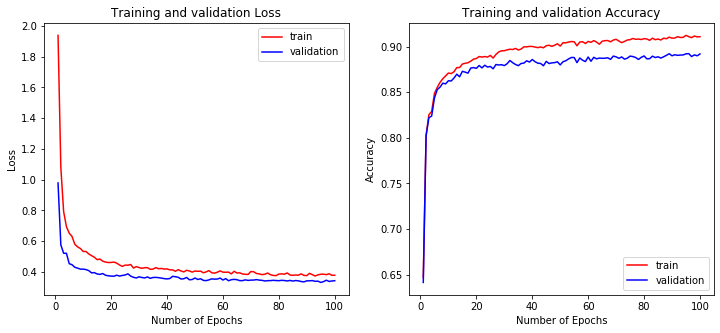

Successfully saving test prediction into the directory of ../Output/


In [58]:
# record starting time
start_time = time.time()

# initialize Multilayer Perceptron
nn = MLP([128, 64, 32, 16, 10], [None, 'relu', 'relu', 'relu', 'softmax'])

# train model
performance = nn.fit(
    X_train_whitening,
    y_train,
    X_validation_whitening,
    y_validation,
    learning_rate=4e-4,
    epochs=100,
    weight_decay=1e-1,
    momentum=0.1,
    dropout=0.1,
    batch_size=256
    )

# record ending time and print time cost of training process
end_time = time.time()
print('The training process costs: ' + str(end_time - start_time) + ' seconds.')
plot_result(*performance)

# perform prediction on test data set and save the result into ../Output directory
test_prediction = nn.predict(X_test_whitening)
with h5py.File('../Output/Predicted_labels.h5','w') as H:
        H.create_dataset('label', data=test_prediction)
print('Successfully saving test prediction into the directory of ../Output/')